In [1]:
# Making imports convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset, concatenate_datasets
import transformers
from sklearn.model_selection import StratifiedKFold

from transformers import AutoTokenizer, DataCollatorWithPadding,AutoModelForSequenceClassification,TrainingArguments,Trainer

from src.utils.myutils import *
import yaml
from tqdm import tqdm
import logging
import json
import warnings
import random
import pandas as pd

logging.disable(logging.ERROR)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

CS_DATA_PATH = PATH + '/data/CS/processed/'
CONFIG_PATH = PATH + '/src/utils/config.yaml'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = 'fav-kky/FERNET-C5'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False,padding=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

BATCH_SIZE = 32

In [11]:
model_path = '/home/horyctom/bias-detection-thesis/src/models/trained/wncs_balanced.pth'

In [3]:
wnc = load_dataset('csv',data_files = CS_DATA_PATH + 'WNC/wnc.csv')['train']

## Train

In [6]:
tokenized = preprocess_data(wnc,tokenizer,'sentence')
tokenized = tokenized.train_test_split(0.2,seed=42)

  0%|          | 0/363 [00:00<?, ?ba/s]

In [9]:
pretraining_args = TrainingArguments(
    num_train_epochs=3,
    per_device_train_batch_size=BATCH_SIZE,  
    per_device_eval_batch_size=BATCH_SIZE,
    eval_steps=1000,
    logging_steps=1000,
    save_steps=5000,
    disable_tqdm = False,
    warmup_steps=0,
    save_total_limit=1,
    evaluation_strategy="steps",
    weight_decay=0.1,
    output_dir = './',
    learning_rate=2e-5)

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized['train'],data_collator=data_collator,
                  tokenizer=tokenizer,eval_dataset=tokenized['test'],compute_metrics=compute_metrics_eval)
trainer.train()

Step,Training Loss,Validation Loss,F1
1000,0.639300,0.621087,0.553218
2000,0.617800,0.605859,0.666092
3000,0.609600,0.595582,0.656912
4000,0.603100,0.597041,0.628197
5000,0.599900,0.595485,0.672082
6000,0.599400,0.589904,0.642536
7000,0.596700,0.588311,0.645611
8000,0.592600,0.588974,0.629292
9000,0.594800,0.587056,0.655791
10000,0.551300,0.620132,0.618082


TrainOutput(global_step=27225, training_loss=0.5476160278880782, metrics={'train_runtime': 9274.7571, 'train_samples_per_second': 93.93, 'train_steps_per_second': 2.935, 'total_flos': 4.240609801448976e+16, 'train_loss': 0.5476160278880782, 'epoch': 3.0})

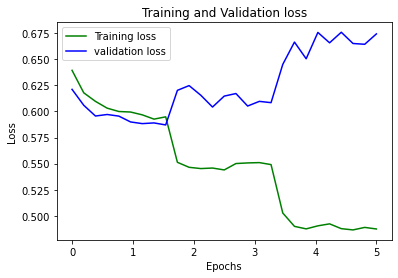

In [13]:
plot_losses(pd.read_csv('wncs.loss',sep='\t'))

## train all

In [14]:
tokenized = preprocess_data(wnc,tokenizer,'sentence')

In [17]:
pretraining_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=32,  
    logging_steps=1000,
    save_steps=5000,
    disable_tqdm = False,
    warmup_steps=0,
    save_total_limit=1,
    weight_decay=0.1,
    output_dir = './',
    learning_rate=2e-5)

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized,data_collator=data_collator,
                  tokenizer=tokenizer)
trainer.train()

torch.save(model.state_dict(),model_path)

Step,Training Loss
1000,0.647000
2000,0.611200
3000,0.608900
4000,0.606400
5000,0.600100
6000,0.599100
7000,0.595100
8000,0.588100
9000,0.587700
10000,0.588000
